In [589]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


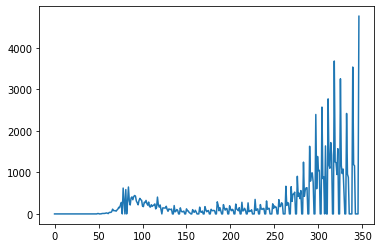

In [590]:
import pandas as pd
import numpy as np
DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv"

df = pd.read_csv(DATA_URI)

DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Deaths.csv"


df_deaths = pd.read_csv(DATA_URI)


cases=df[df.location_name=="Rhode Island"]
deaths=df_deaths[df_deaths.location_name=="Rhode Island"]
joined_df = cases.set_index('date').join(deaths.set_index('date'),how='left',lsuffix='cases',rsuffix='deaths')
plt.plot(cases.value.values)

In [592]:
import patsy
import numpy as np

df_full = pd.DataFrame({'X':np.arange(len(joined_df.valuecases.tolist())),
                   'Y':np.array(joined_df.valuecases.tolist()),  # add your data here
                    'D': np.array(joined_df.valuedeaths.tolist())})
                  
df_train =df_full

df_train.Y=df_train.Y.replace(0, np.NaN).interpolate()

df_train.D= df_train.D.replace(0, np.NaN).interpolate()




B = patsy.dmatrix('bs(X, knots=np.arange(df_train.X.values[0],df_train.X.values[-1]+27,20), degree=3)',  pd.DataFrame({'X':np.arange(len(joined_df.valuecases.tolist())+27)}), 
                  return_type='matrix')

num_data, num_basis = B.shape
print (B.shape)

(374, 23)


In [582]:
def exp_pdf(lambda_,x):
    return (lambda_*np.exp(-lambda_*x))

In [583]:
df_train.D

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
30            NaN
31            NaN
32            NaN
33            NaN
34            NaN
35            NaN
36            NaN
37            NaN
38            NaN
39            NaN
40            NaN
41            NaN
42            NaN
43            NaN
44            NaN
45            NaN
46            NaN
47            NaN
48            NaN
49            NaN
50            NaN
51            NaN
52            NaN
53            NaN
54            NaN
55        

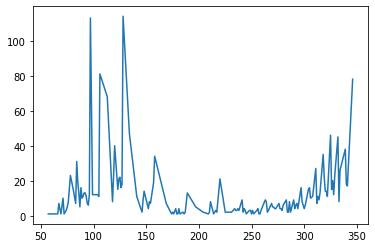

In [584]:
plt.plot(df_train.D.values)

In [585]:
import sys
np.set_printoptions(threshold=sys.maxsize)
import math
# building the expnential distribution mask
lambda_ = 21
mask = np.zeros((num_data,num_data))
for i in np.arange(num_data):
    tmp=np.flip(exp_pdf(21,np.arange(num_data))[:(i+1)])
    mask[i,:(i+1)]=tmp
        


In [586]:
def LogisticRandomWalk(loc=1., scale=1e-2, drift=0., num_steps=100):
    '''
    Return distrubtion of exponentiated Gaussian random walk
   
    Variables are x_0, ..., x_{T-1}
   
    Dynamics in log-space are random walk with drift:
       log(x_0) := log(loc)
       log(x_t) := log(x_{t-1}) + drift + eps_t,    eps_t ~ N(0, scale)
    
    ==> Dynamics in non-log space are:
        x_0 := loc
        x_t := x_{t-1} * exp(drift + eps_t),    eps_t ~ N(0, scale)
    '''
   
    logistic_loc = np.log(loc/(1-loc)) + drift * (np.arange(num_steps)+0.)
   
    return dist.TransformedDistribution(
        dist.GaussianRandomWalk(scale=scale, num_steps=num_steps),
        [
            dist.transforms.AffineTransform(loc = logistic_loc, scale=1.),
            dist.transforms.SigmoidTransform()
        ]
    )

In [587]:

def model(B_local=None,Forecast=False,Forecast_det_prob=None,mask=None):
    if Forecast==False:
        det_prob = numpyro.sample("det_prob",
                                      LogisticRandomWalk(loc=.01, 
                                                         scale=5e-2, 
                                                         drift=0.,
                                                         num_steps=num_data))
    
    else:
        det_prob=Forecast_det_prob
    a_raw =numpyro.sample('a_raw',dist.Normal(jnp.zeros(num_basis),1000*jnp.ones(num_basis)))
    sigma = numpyro.sample('sigma', dist.Exponential(10))
    sigma2 = numpyro.sample('sigma2', dist.Exponential(100))

    y_hat =  numpyro.deterministic('c', jnp.dot(jnp.array(B_local), a_raw))
    y = numpyro.sample('y', dist.Normal(y_hat, sigma2), obs=df_train.Y.values)
   
    y_hat_masked = jnp.matmul(mask,y_hat)
    d_hat = jnp.flip(numpyro.deterministic('d', det_prob*y_hat_masked))
  
    #print (np.transpose(y_hat_tiled))

    numpyro.sample('d_obs', dist.Normal(det_prob*y_hat_masked, sigma), obs=df_train.D.values)

    #numpyro.sample('d',dist.Normal(d_hat,10),obs=df_train.D)

In [588]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_,B_local=B,Forecast=False,Forecast_det_prob=None,mask=mask)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

TypeError: sub got incompatible shapes for broadcasting: (347,), (374,).

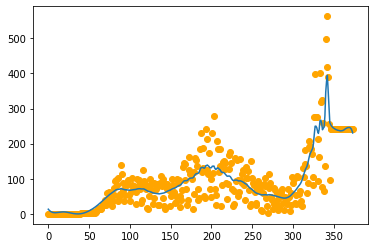

In [569]:
plt.plot(df_train.X.values,samples_1['d'].mean(axis=0))
plt.scatter(df_train.X.values,df_train.D.values,color='orange')

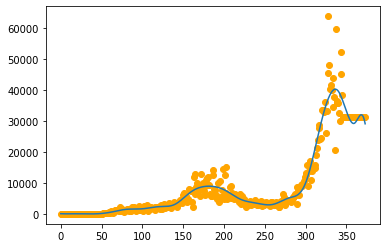

In [570]:
plt.plot(df_train.X.values,samples_1['c'].mean(axis=0))
plt.scatter(df_train.X.values,df_train.Y.values,color='orange')

In [571]:
lambda_ = 21
forecast_mask = np.zeros((27,27))
for i in np.arange(27):
    for j in np.arange(27):
        if j-i >=0:
            tmp = exp_pdf(lambda_,np.abs(i-j))
            if math.isinf(tmp):
                forecast_mask[27-i-1,j] = 0
            else:
                forecast_mask[27-i-1,j] = tmp
        else:
            forecast_mask[27-i-1,j] = 0
        

In [572]:
new_data = {"X":np.arange(df_train.X.values[-1]-27,df_train.X.values[-1],1)}

B_predict = patsy.build_design_matrices([B.design_info], new_data)[0]
from numpyro.infer import Predictive
det_prob_forecast= samples_1['det_prob'].mean(axis=0)[-1]
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_,B_local=B_predict,Forecast=True,Forecast_det_prob=det_prob_forecast,mask=forecast_mask)['d']


In [573]:
predictions.shape

(2000, 27)

401


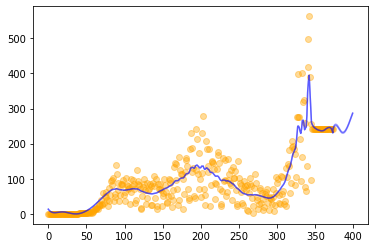

In [574]:
full_mean = np.concatenate((samples_1['d'].mean(axis=0),predictions.mean(axis=0)))
full_upq = np.concatenate((samples_1['d'].mean(axis=0),np.quantile(predictions,.975,axis=0)))
full_lrq = np.concatenate((samples_1['d'].mean(axis=0),np.quantile(predictions,.025,axis=0)))

print (len(full_upq))
full_mean_x = np.concatenate((df_train.X.values,np.arange(df_train.X.values[-1],df_train.X.values[-1]+27)))
#plt.plot(full_mean_x,full_mean)
plt.scatter(df_train.X.values,df_train.D.values,color='orange',alpha=.4)
plt.plot(full_mean_x,full_upq,color='blue',alpha=.4)
plt.plot(full_mean_x,full_lrq,color='blue',alpha=.4)



/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


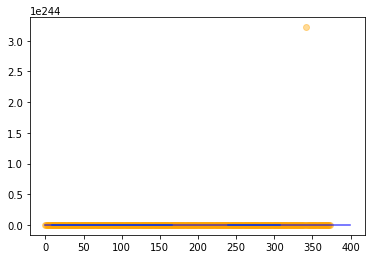

In [563]:
plt.plot(full_mean_x,np.exp(full_mean))
plt.scatter(df_train.X.values,np.exp(df_train.D.values),color='orange',alpha=.4)
plt.plot(full_mean_x,np.exp(full_upq),color='blue',alpha=.4)
plt.plot(full_mean_x,np.exp(full_lrq),color='blue',alpha=.4)